### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGES = os.path.join(DATASET, 'images/')
DOWNLOAD = False
SHAPE = (224, 224)
LABEL = 'DR_ICDR'
IMAGE_COL = 'image_id'
TEST_SIZE = 0.3
UNDERSAMPLE = False

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'dinov2_base'
MODE = 'fine_tune'
backbone_mode='fine_tune'

HIDDEN = None
num_classes = 3

BATCH_SIZE = 8
NUM_WORKERS = 2

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 15
learning_rate = 5e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))


Train data shape: (1208, 35)
Test data shape: (4880, 35)


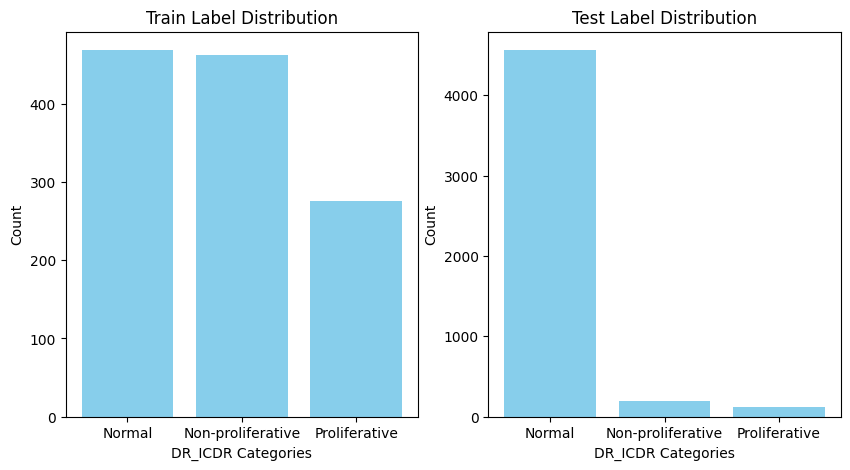

Getting validation set...
Train data shape: (4148, 35)
Test data shape: (732, 35)


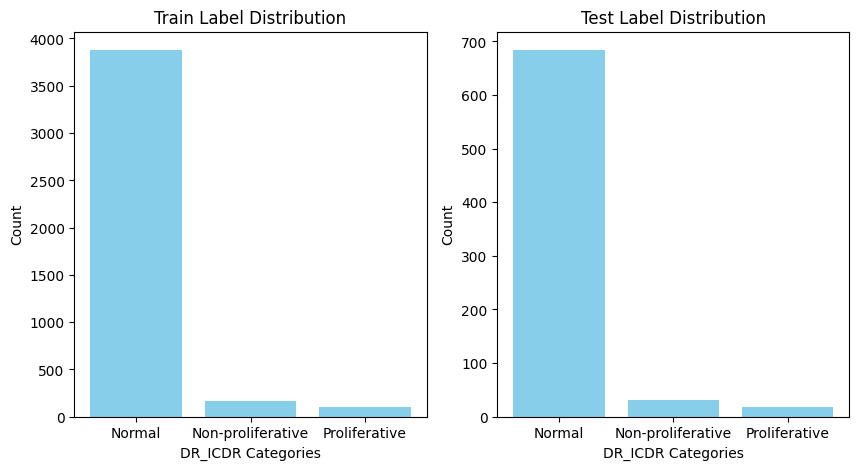

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=True, undersample_ratio=1.7)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.15)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


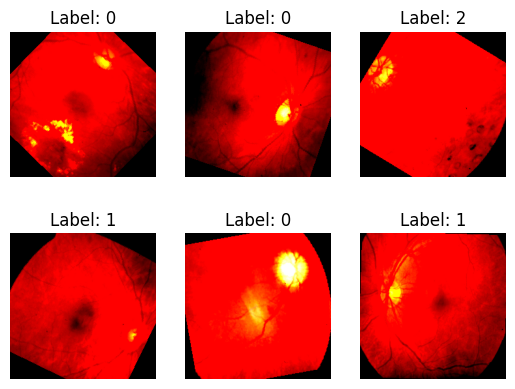

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/home/opc/FoundationalRetina/Weights/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using cache found in /home/opc/.cache/torch/hub/facebookresearch_dinov2_main


Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [463 469 276]


100%|██████████| 151/151 [00:46<00:00,  3.25it/s]


Epoch 1, Training Loss: 0.2609262435838876


100%|██████████| 92/92 [00:26<00:00,  3.51it/s]


Epoch 1, Validation Loss: 0.24797803074445413, F1 Score: 0.364245770519842


100%|██████████| 151/151 [00:42<00:00,  3.55it/s]


Epoch 2, Training Loss: 0.2491208321803453


100%|██████████| 92/92 [00:25<00:00,  3.65it/s]


Epoch 2, Validation Loss: 0.10293333582661074, F1 Score: 0.5276002962670187


100%|██████████| 151/151 [00:43<00:00,  3.46it/s]


Epoch 3, Training Loss: 0.2125540514852827


100%|██████████| 92/92 [00:25<00:00,  3.62it/s]


Epoch 3, Validation Loss: 0.12336688790389377, F1 Score: 0.47183023161268256


100%|██████████| 151/151 [00:43<00:00,  3.47it/s]


Epoch 4, Training Loss: 0.21361863748818044


100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Epoch 4, Validation Loss: 0.09368780172308502, F1 Score: 0.5973924715935945


100%|██████████| 151/151 [00:43<00:00,  3.50it/s]


Epoch 5, Training Loss: 0.1769592608294345


100%|██████████| 92/92 [00:25<00:00,  3.64it/s]


Epoch 5, Validation Loss: 0.20859558718359988, F1 Score: 0.46913517768780927


100%|██████████| 151/151 [00:42<00:00,  3.54it/s]


Epoch 6, Training Loss: 0.18812621453937317


100%|██████████| 92/92 [00:25<00:00,  3.64it/s]


Epoch 6, Validation Loss: 0.09156996418681482, F1 Score: 0.6171691757528256


100%|██████████| 151/151 [00:43<00:00,  3.47it/s]


Epoch 7, Training Loss: 0.17103294085785253


100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Epoch 7, Validation Loss: 0.10994275918473369, F1 Score: 0.5818266967377775


100%|██████████| 151/151 [00:42<00:00,  3.51it/s]


Epoch 8, Training Loss: 0.1667134885410994


100%|██████████| 92/92 [00:25<00:00,  3.62it/s]


Epoch 8, Validation Loss: 0.07229931018841655, F1 Score: 0.67729196677415


100%|██████████| 151/151 [00:42<00:00,  3.51it/s]


Epoch 9, Training Loss: 0.16751684944163883


100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Epoch 9, Validation Loss: 0.04121688518511212, F1 Score: 0.7499471673575551


100%|██████████| 151/151 [00:43<00:00,  3.45it/s]


Epoch 10, Training Loss: 0.15562496265236114


100%|██████████| 92/92 [00:25<00:00,  3.54it/s]


Epoch 10, Validation Loss: 0.05763209416814472, F1 Score: 0.6757743496197052


100%|██████████| 151/151 [00:43<00:00,  3.49it/s]


Epoch 11, Training Loss: 0.16754207486249753


100%|██████████| 92/92 [00:25<00:00,  3.62it/s]


Epoch 11, Validation Loss: 0.06970383548785163, F1 Score: 0.6402437916980487


100%|██████████| 151/151 [00:43<00:00,  3.45it/s]


Epoch 12, Training Loss: 0.16126959320675854


100%|██████████| 92/92 [00:25<00:00,  3.62it/s]


Epoch 12, Validation Loss: 0.10927727385221617, F1 Score: 0.5393924612104904


100%|██████████| 151/151 [00:43<00:00,  3.46it/s]


Epoch 13, Training Loss: 0.15118255307096123


100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Epoch 13, Validation Loss: 0.10556612657788007, F1 Score: 0.5882060036989615


100%|██████████| 151/151 [00:43<00:00,  3.46it/s]


Epoch 14, Training Loss: 0.1419768128729123


100%|██████████| 92/92 [00:25<00:00,  3.62it/s]


Epoch 14, Validation Loss: 0.060041849278723414, F1 Score: 0.6647237369269612


100%|██████████| 151/151 [00:43<00:00,  3.48it/s]


Epoch 15, Training Loss: 0.1316458061460825


100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Epoch 15, Validation Loss: 0.0924415182646202, F1 Score: 0.553292394173667


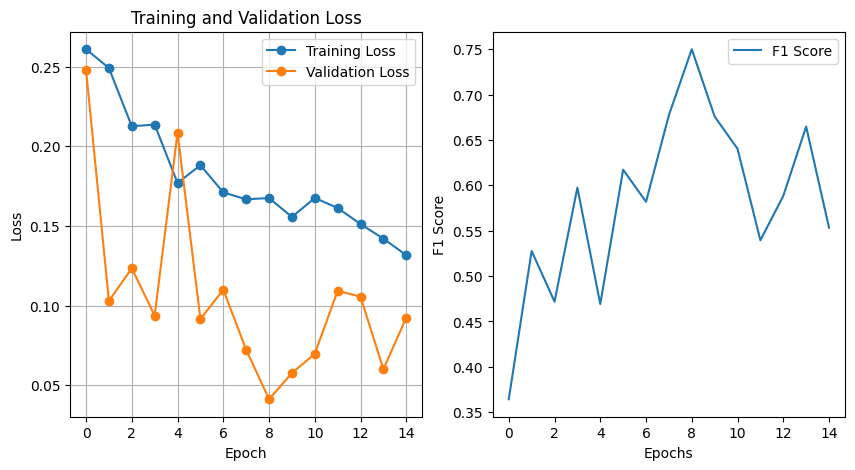

Training finished.


In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=False, device=device)

### Test

100%|██████████| 519/519 [02:26<00:00,  3.54it/s]


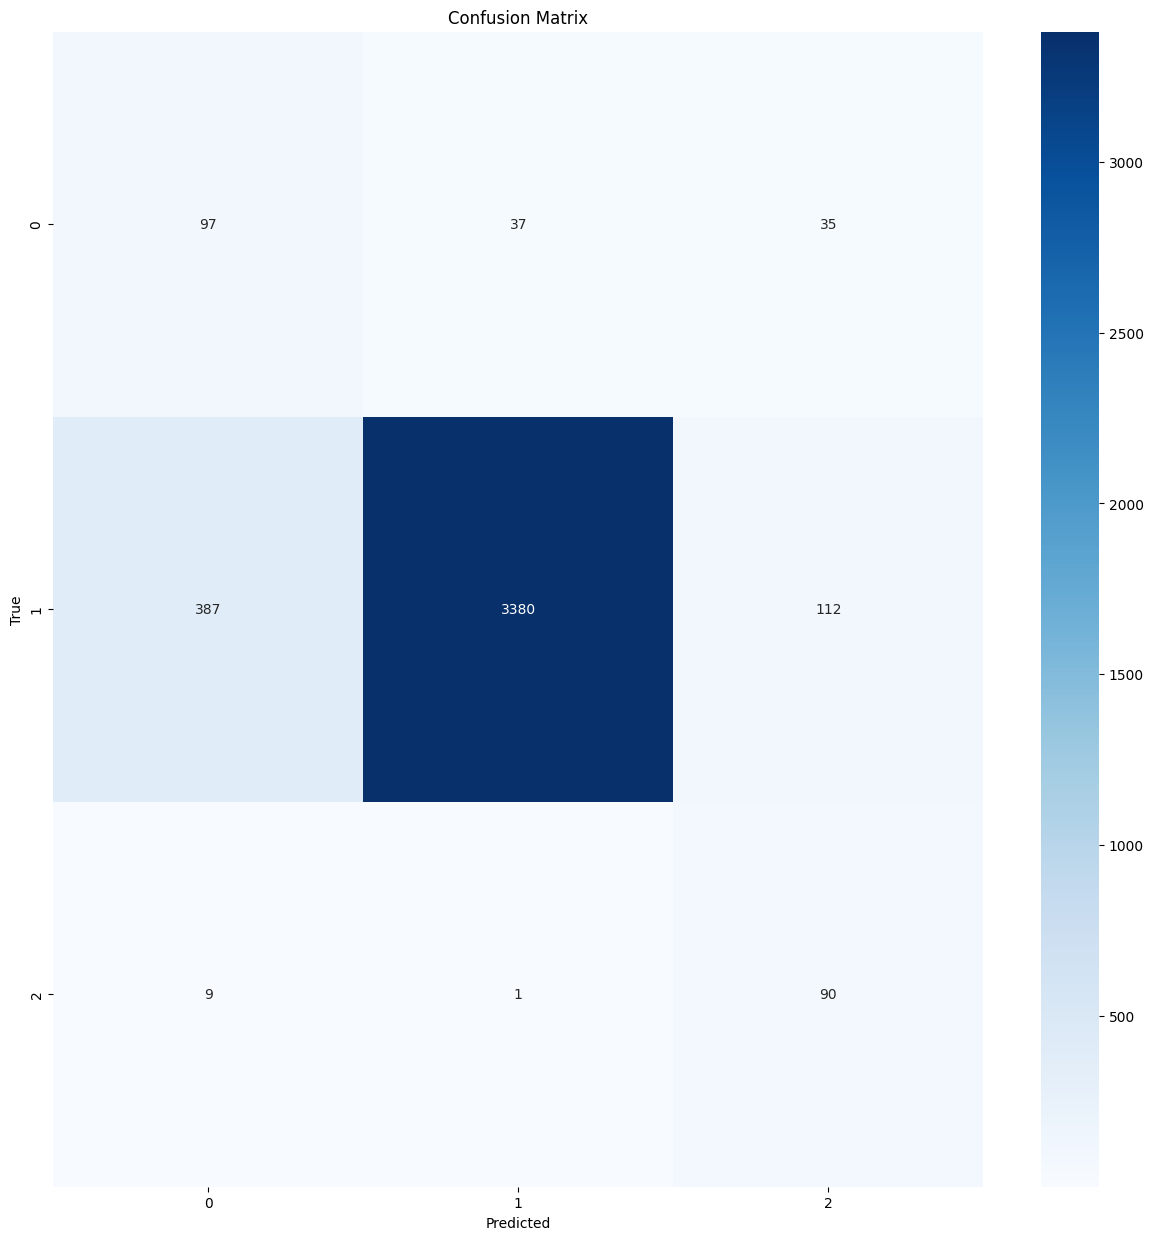

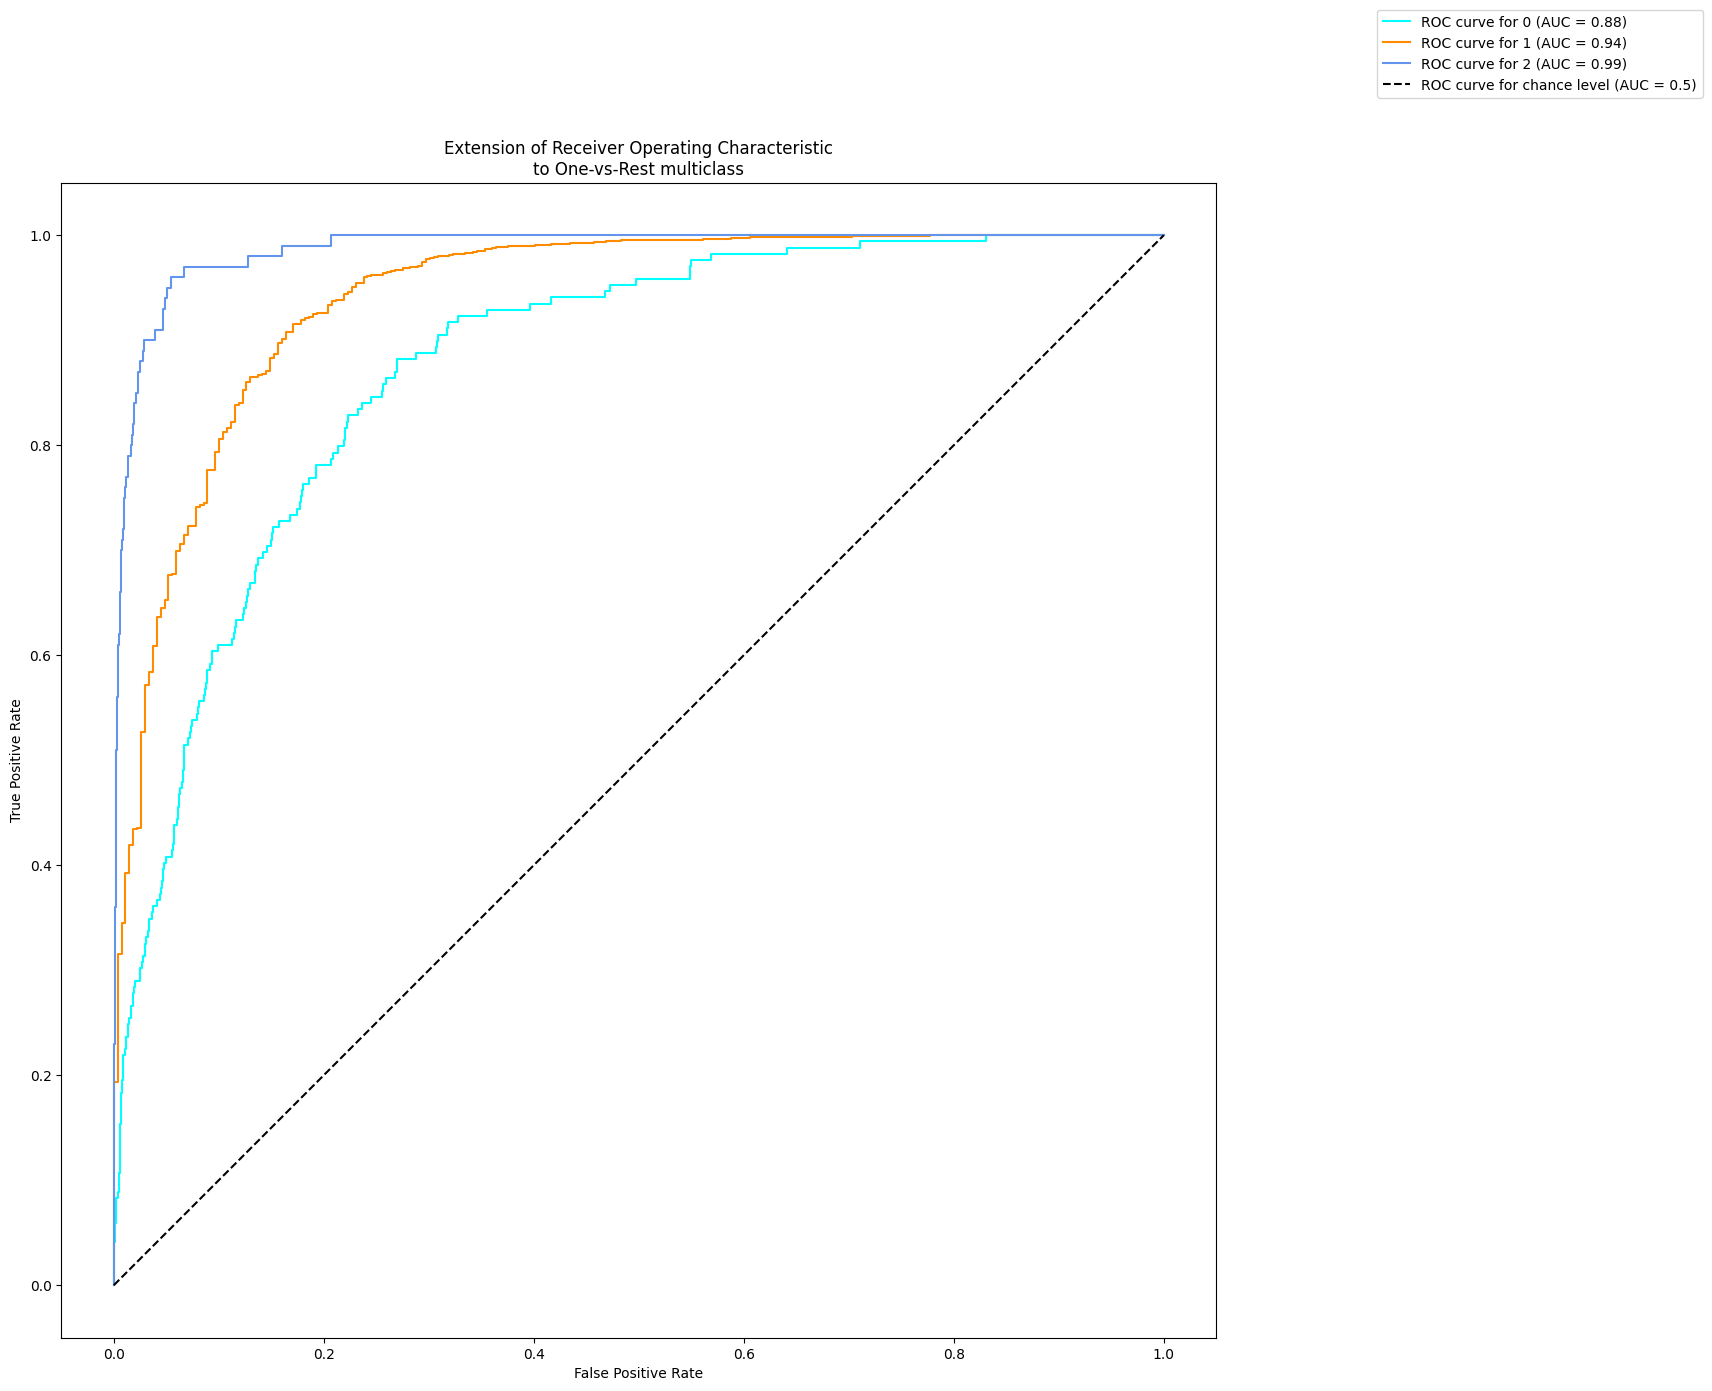

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.20      0.57      0.29       169
           1       0.99      0.87      0.93      3879
           2       0.38      0.90      0.53       100

    accuracy                           0.86      4148
   macro avg       0.52      0.78      0.58      4148
weighted avg       0.94      0.86      0.89      4148

##################################################  Saliency Maps  ##################################################

Class 0:


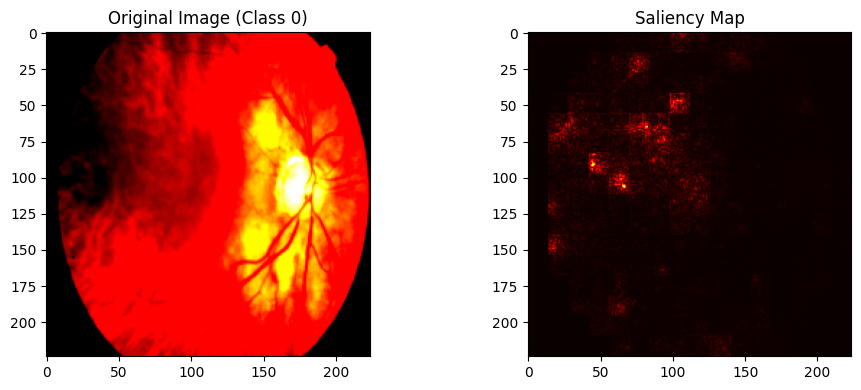

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


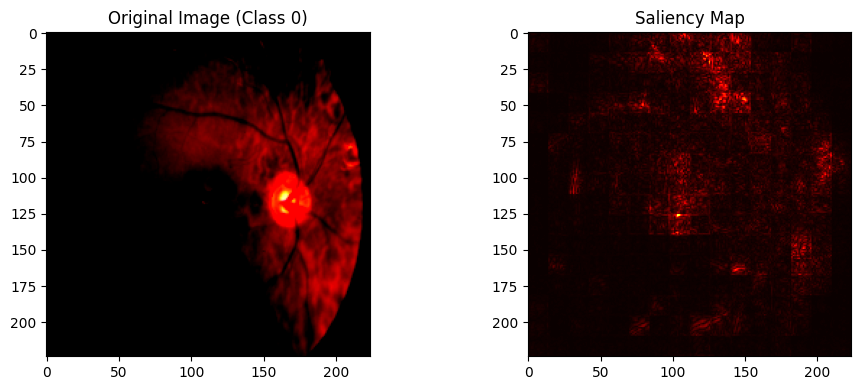

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


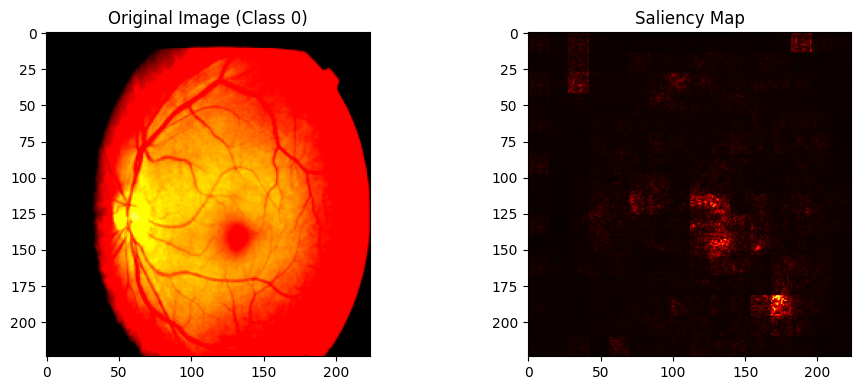

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


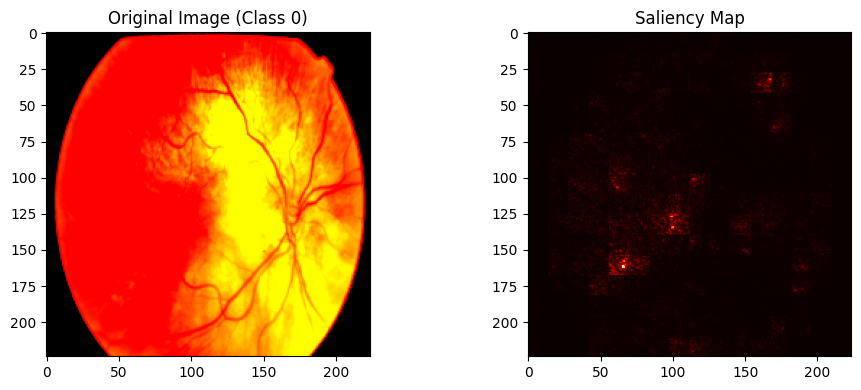

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


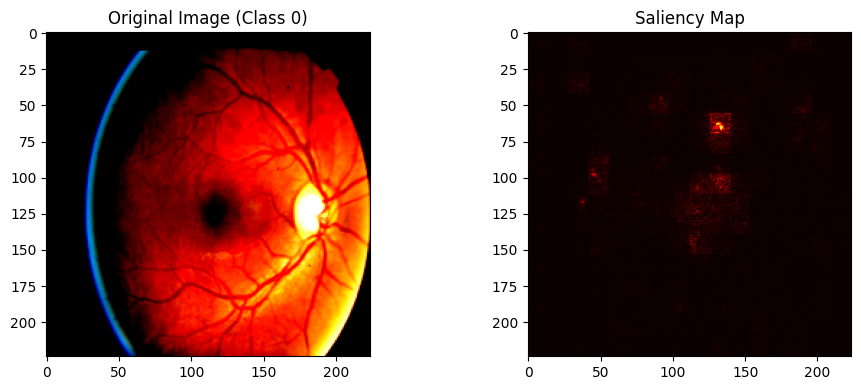

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


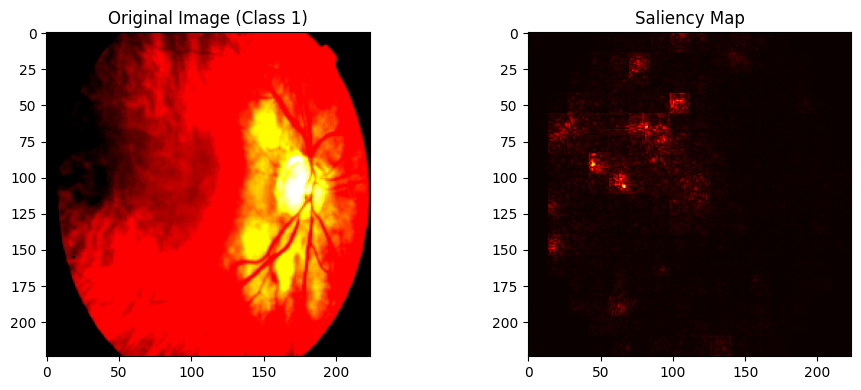

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


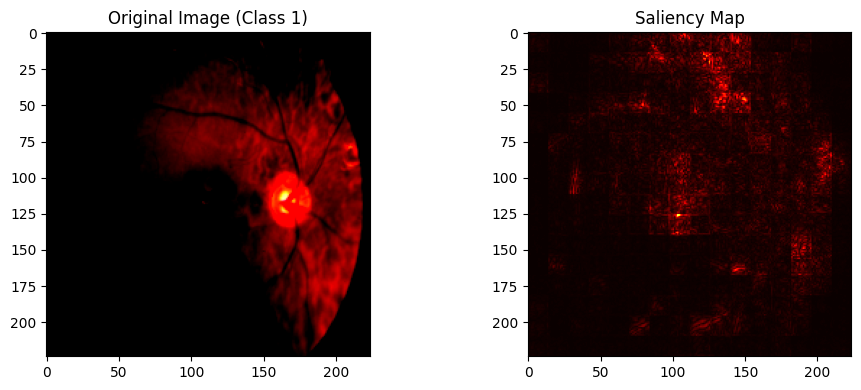

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


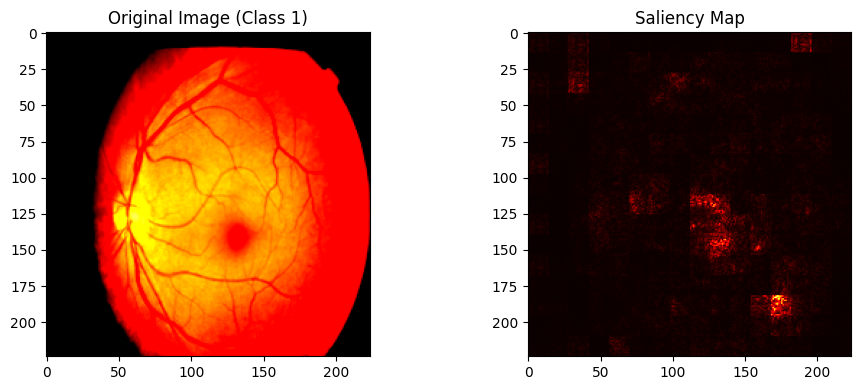

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


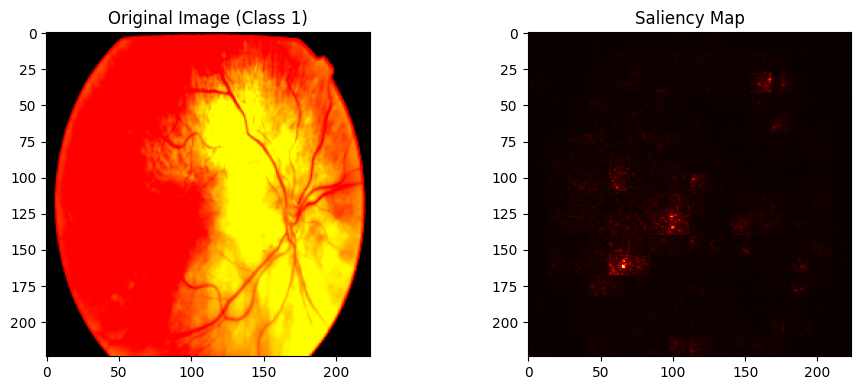

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


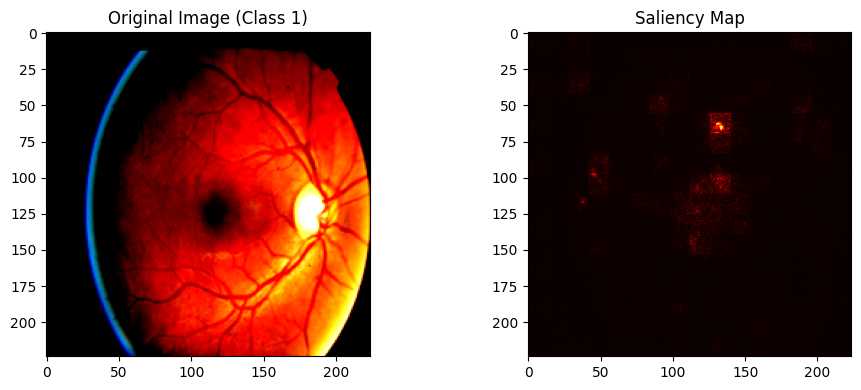

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


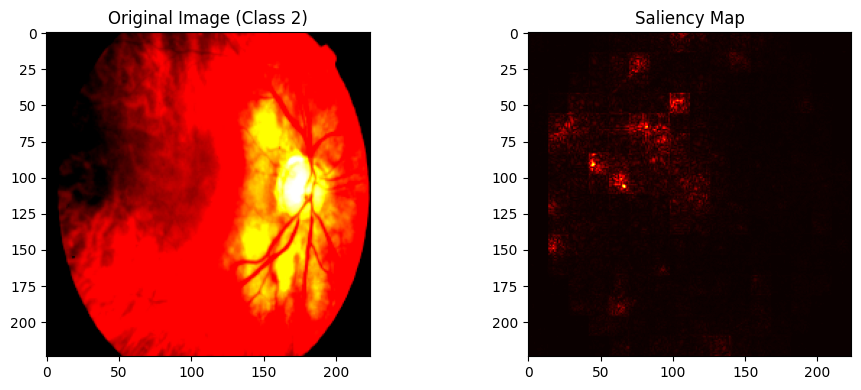

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


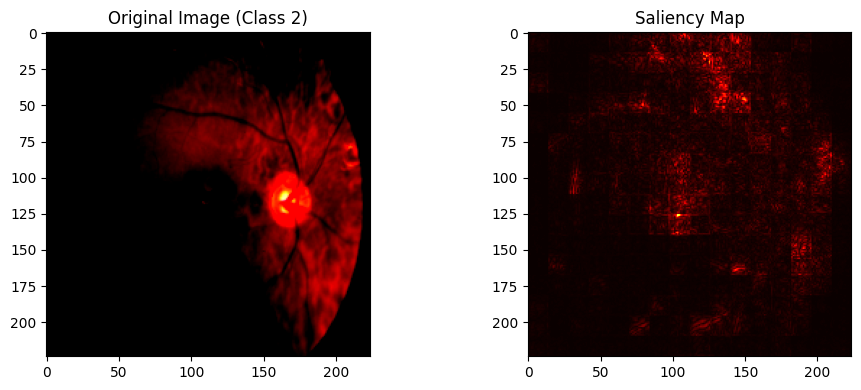

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


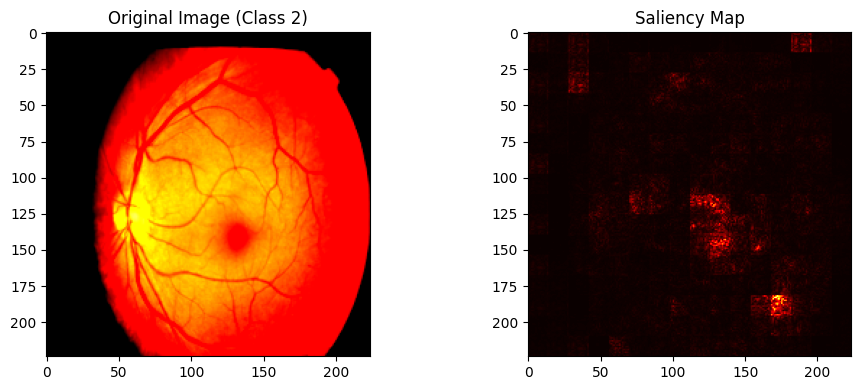

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


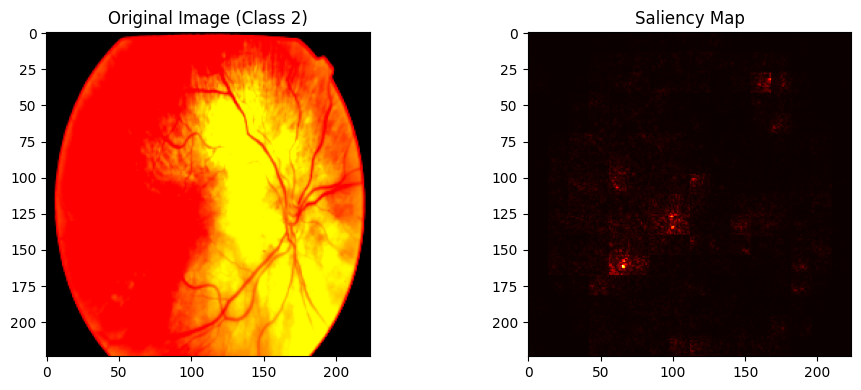

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


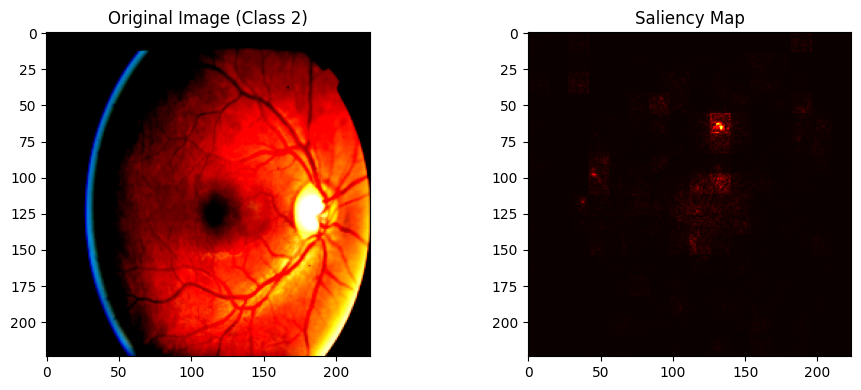

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 456/456 [02:04<00:00,  3.67it/s]


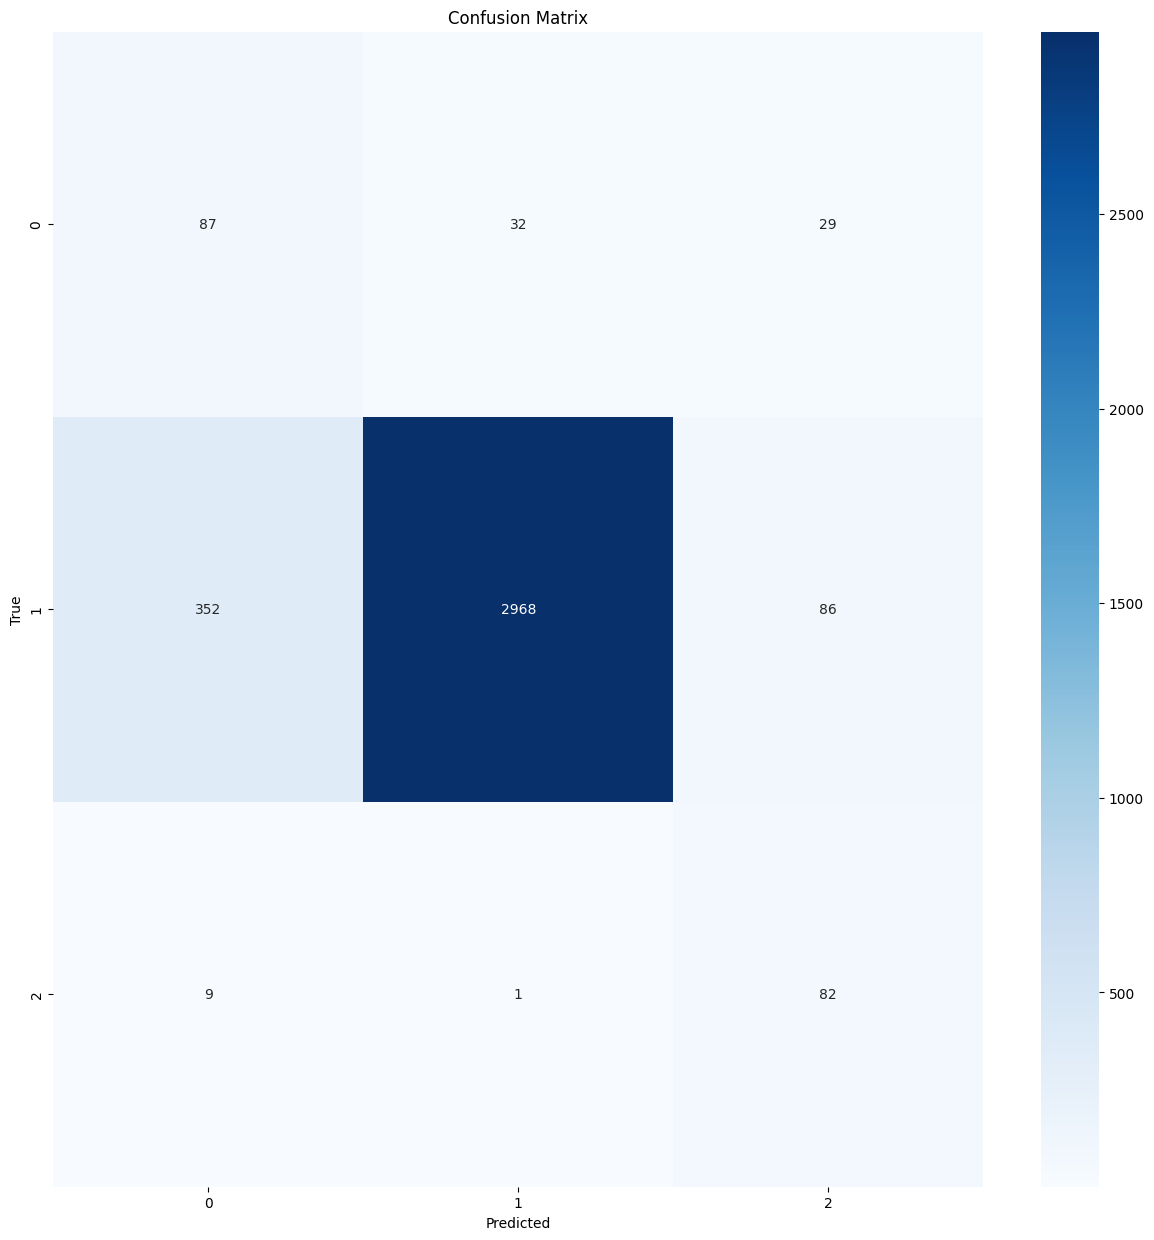

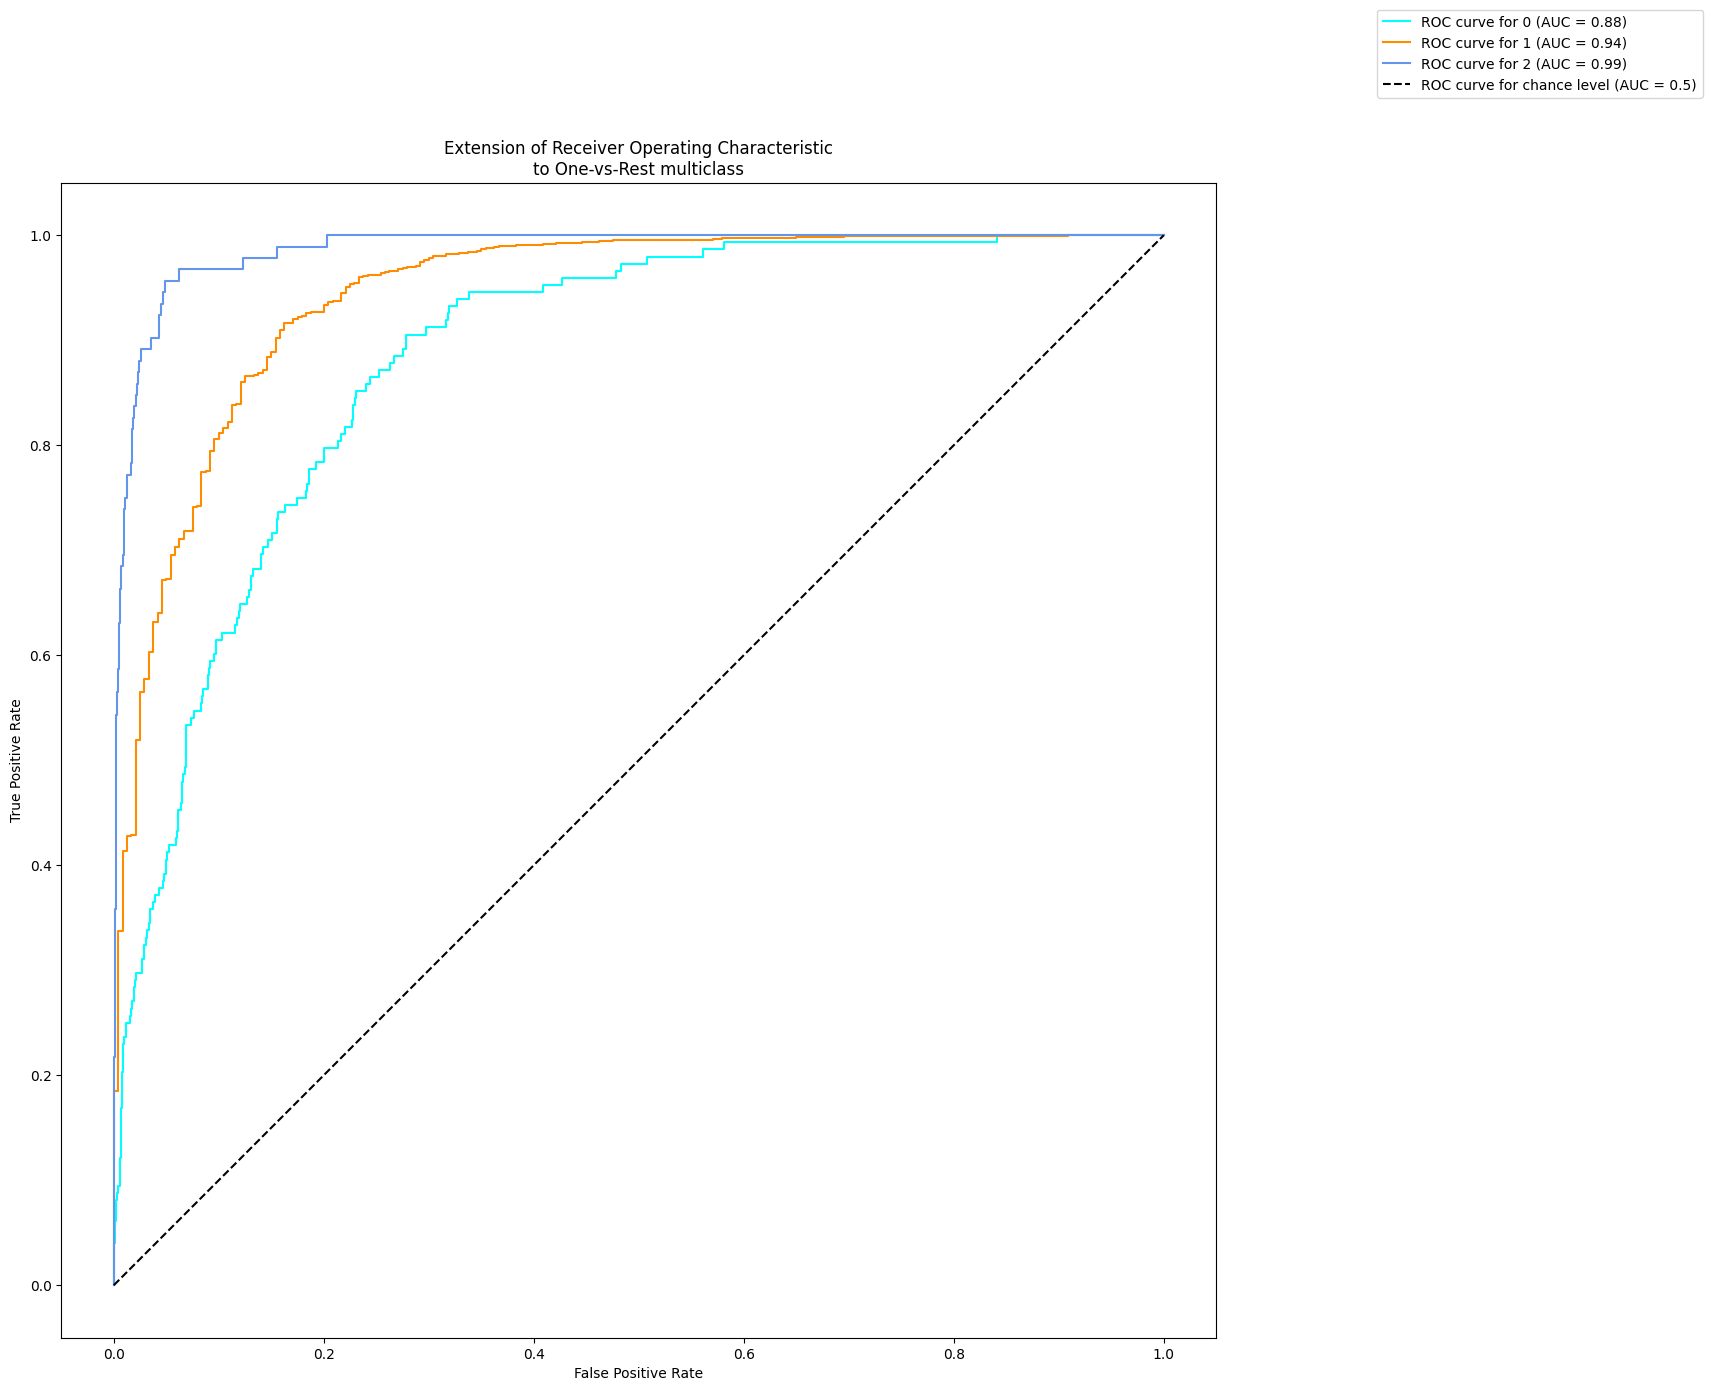

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.19      0.59      0.29       148
           1       0.99      0.87      0.93      3406
           2       0.42      0.89      0.57        92

    accuracy                           0.86      3646
   macro avg       0.53      0.78      0.60      3646
weighted avg       0.94      0.86      0.89      3646

##################################################  Saliency Maps  ##################################################

Class 0:


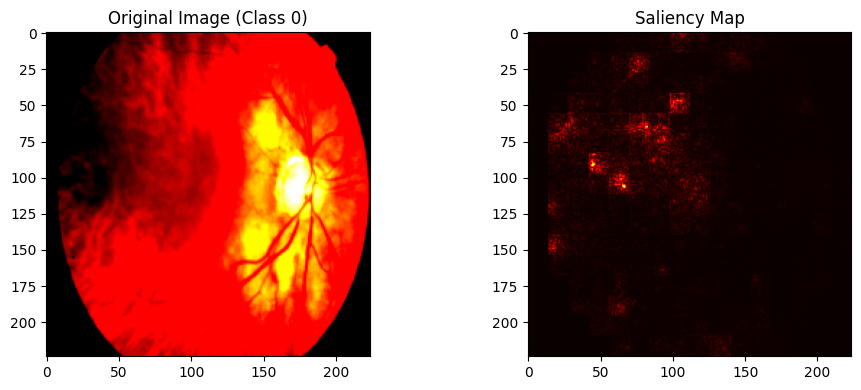

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


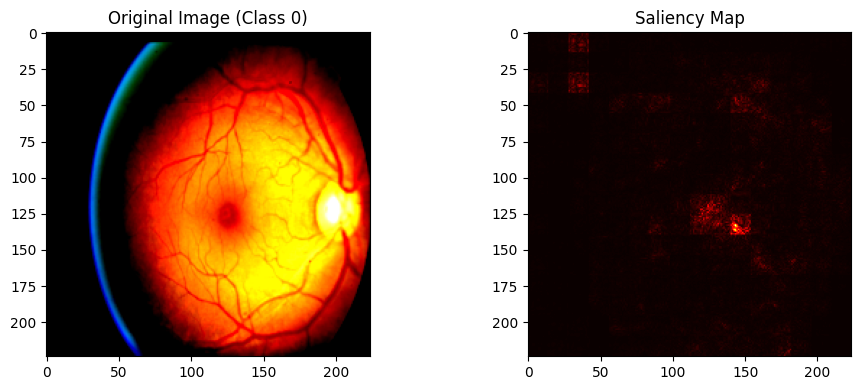

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


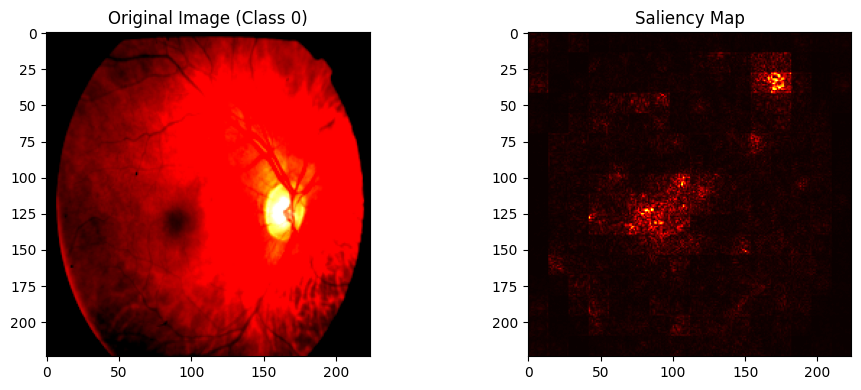

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


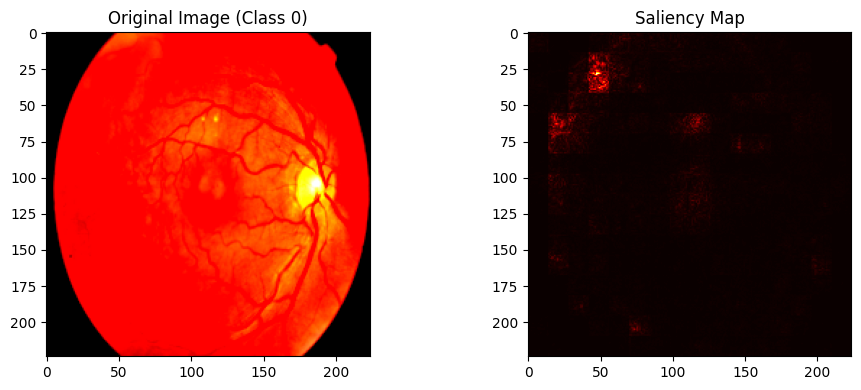

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


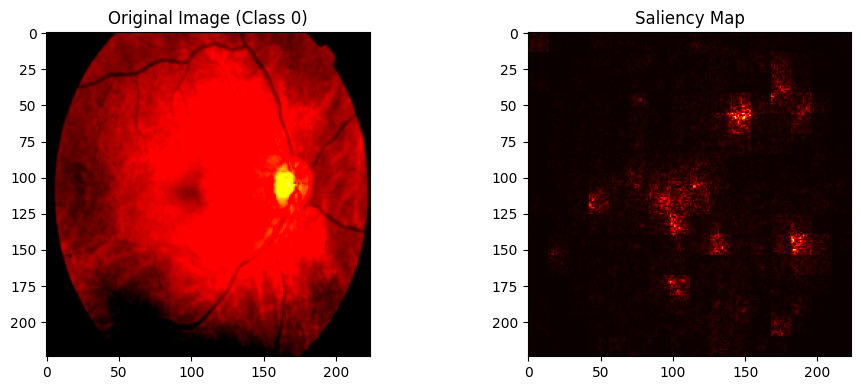

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


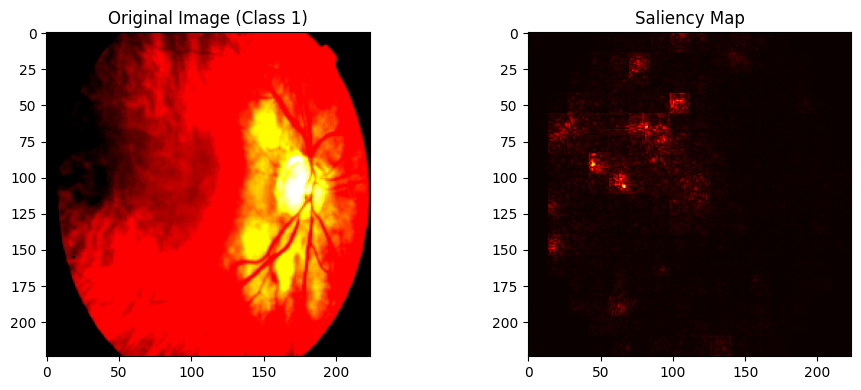

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


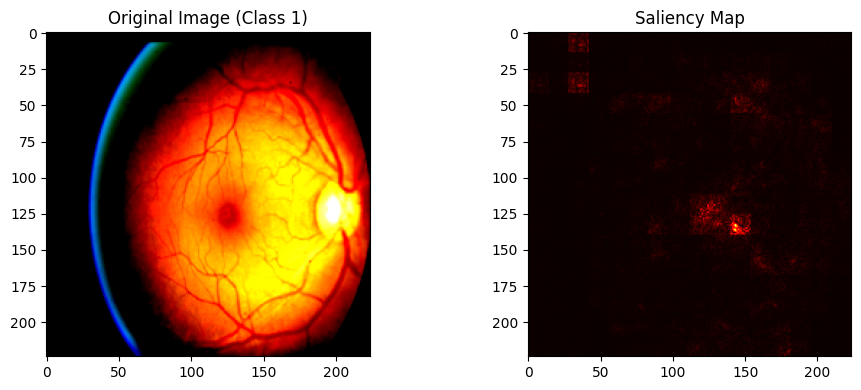

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


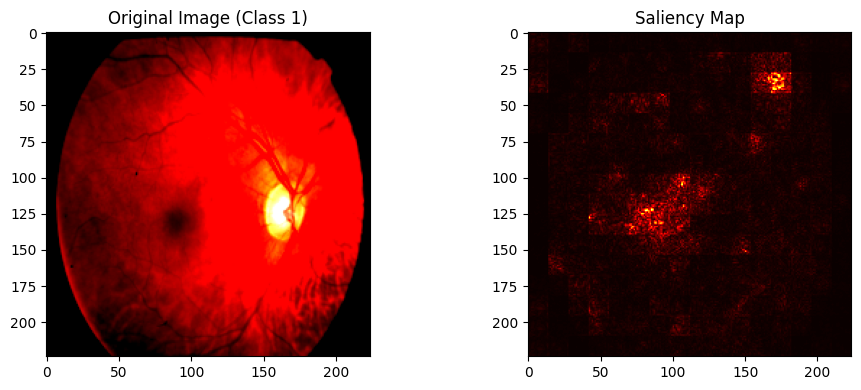

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


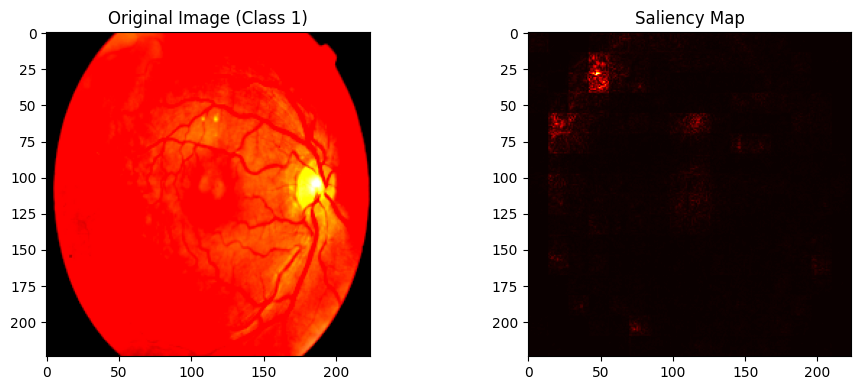

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


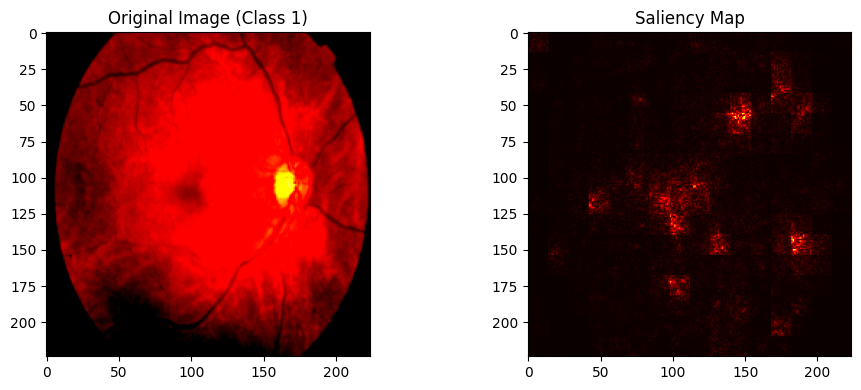

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


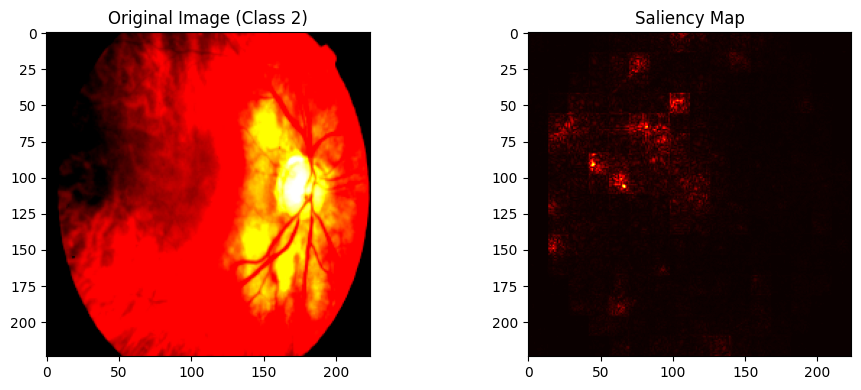

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


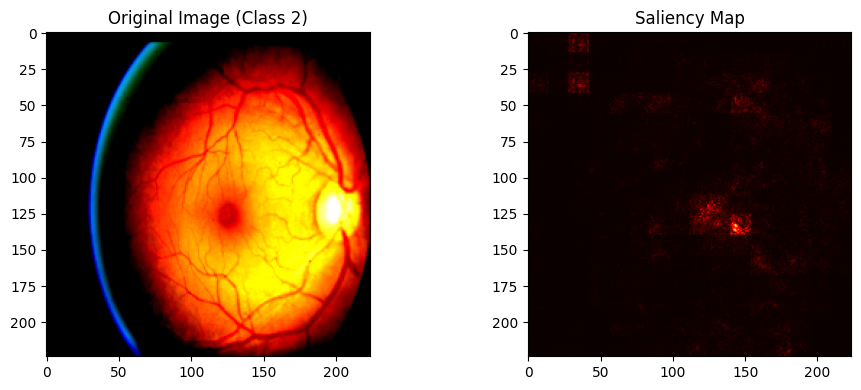

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


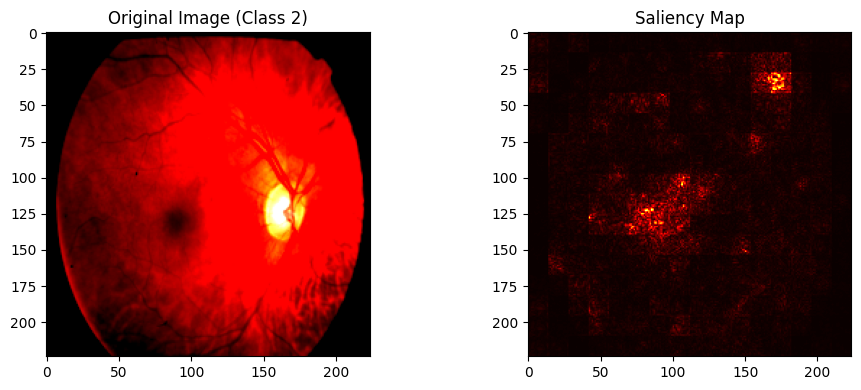

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


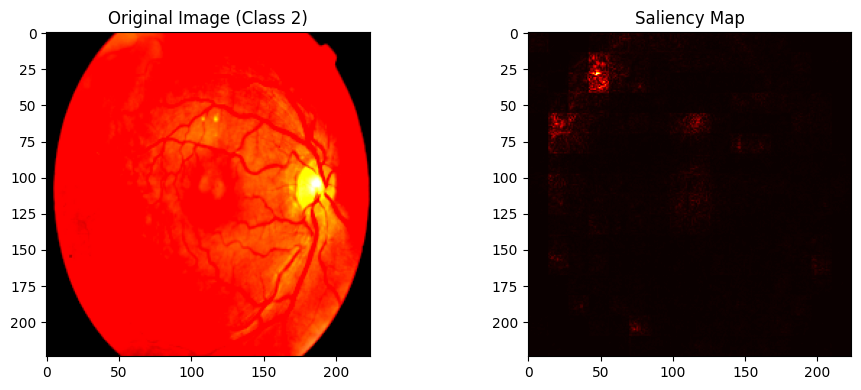

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


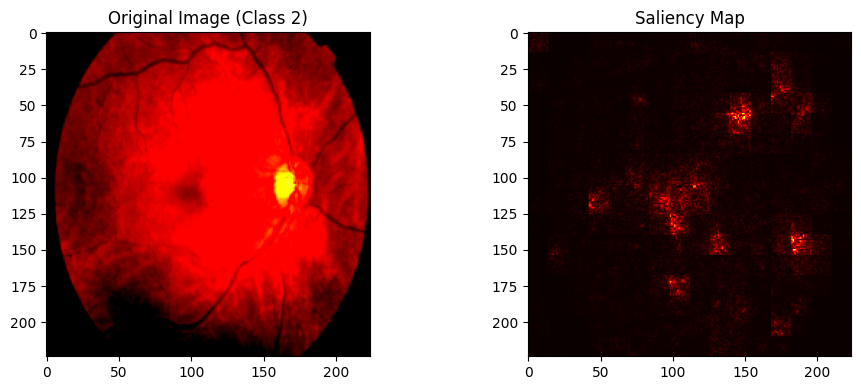

In [15]:
test(model, adequate_dataloader, saliency=True, device=device)

#### Inadequate image quality

100%|██████████| 63/63 [00:18<00:00,  3.39it/s]


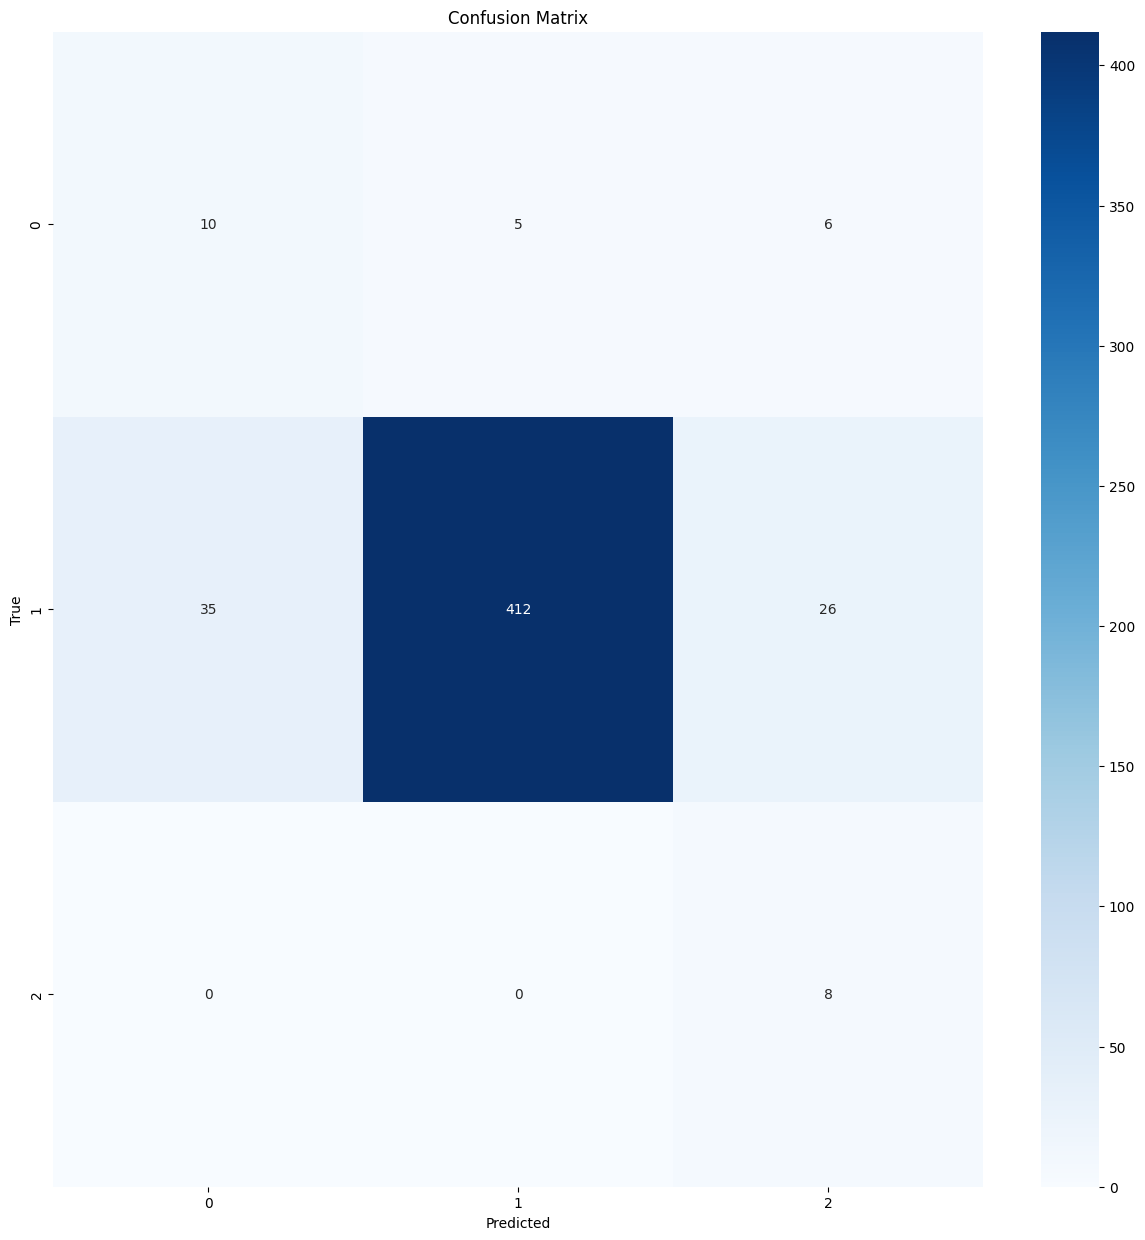

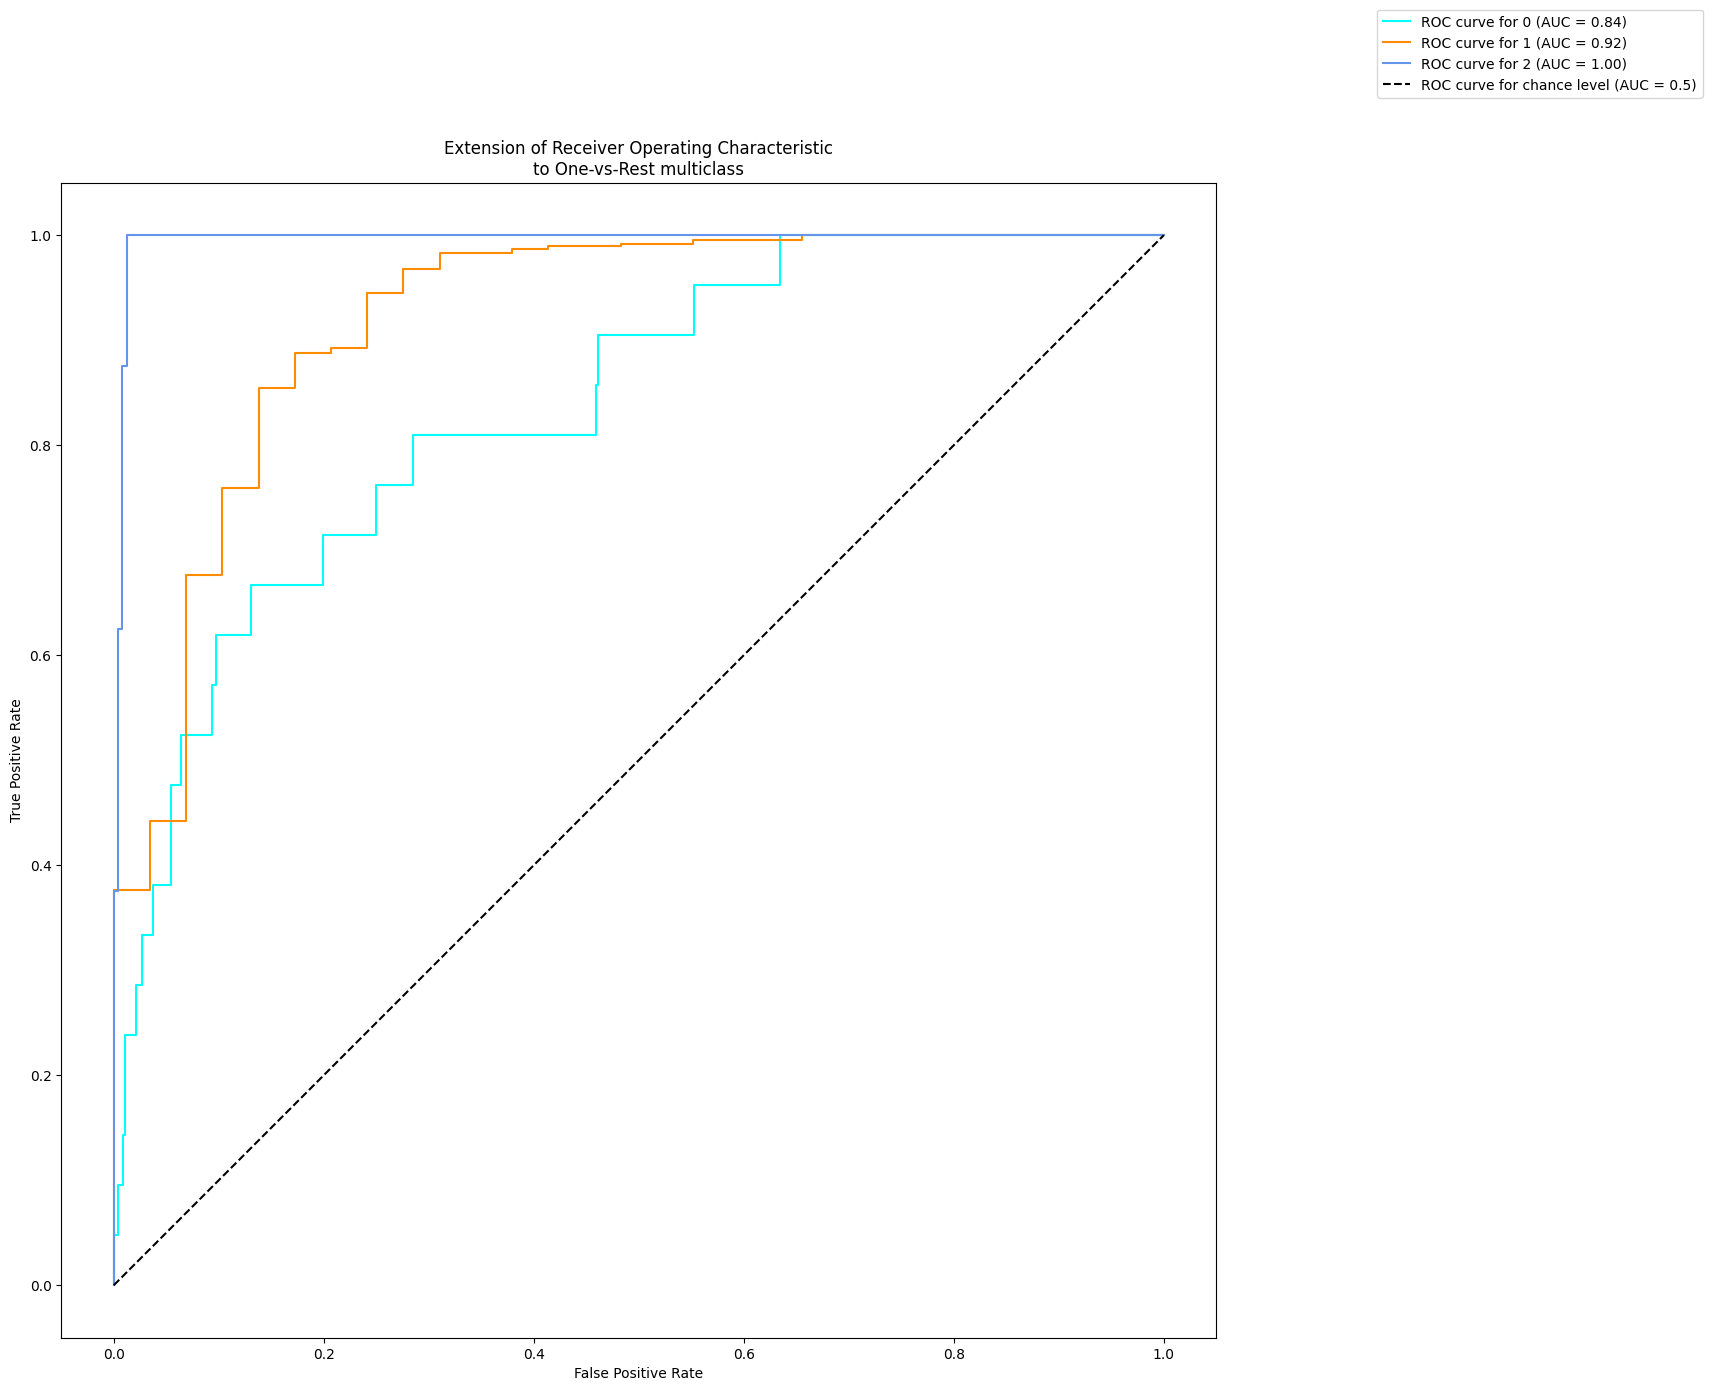

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.22      0.48      0.30        21
           1       0.99      0.87      0.93       473
           2       0.20      1.00      0.33         8

    accuracy                           0.86       502
   macro avg       0.47      0.78      0.52       502
weighted avg       0.94      0.86      0.89       502

##################################################  Saliency Maps  ##################################################

Class 0:


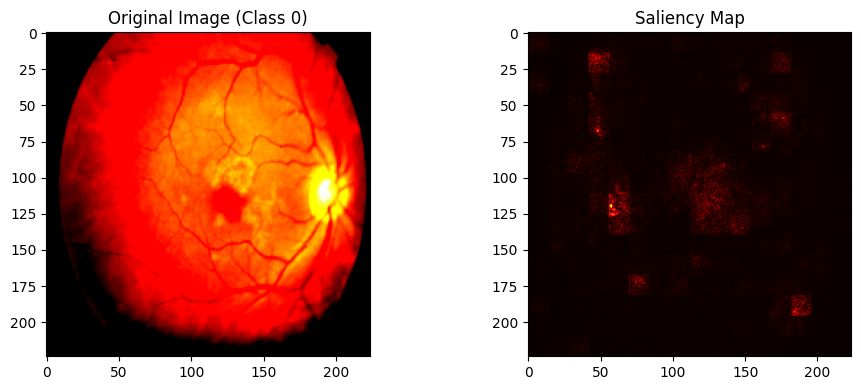

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


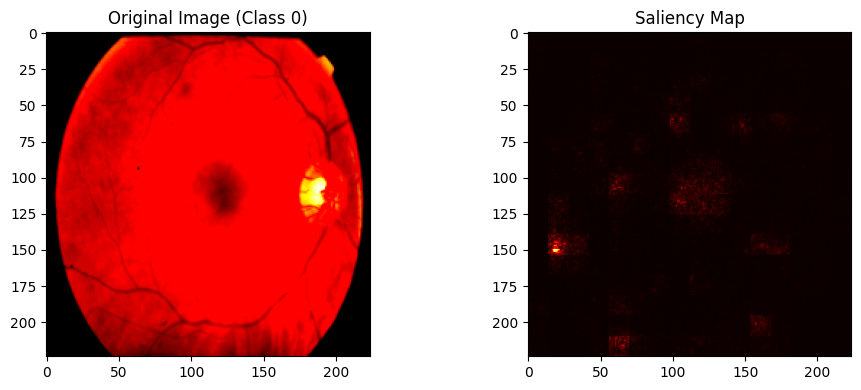

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


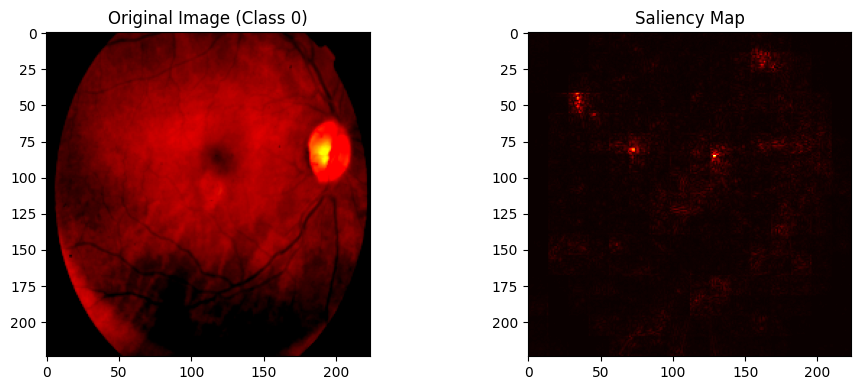

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


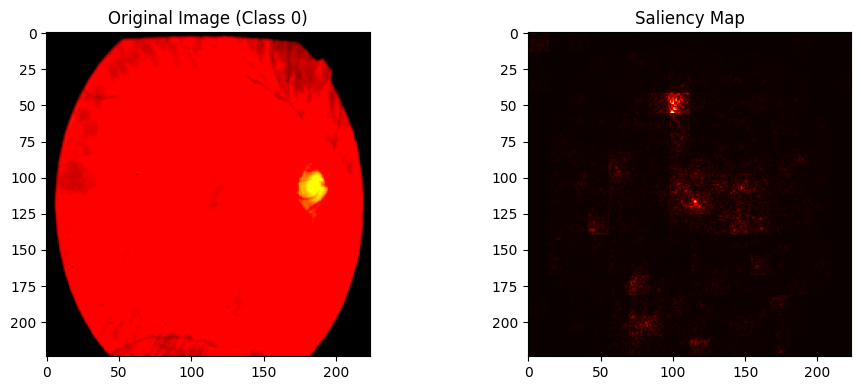

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


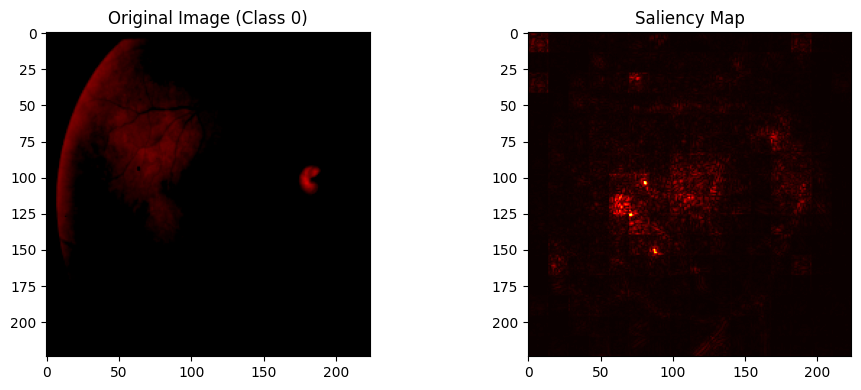

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


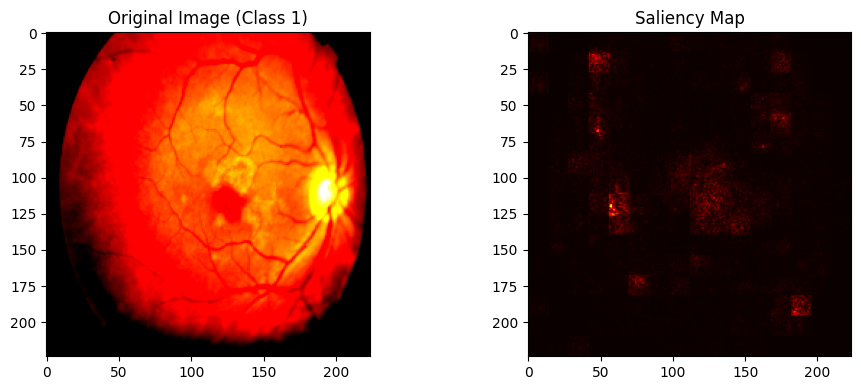

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


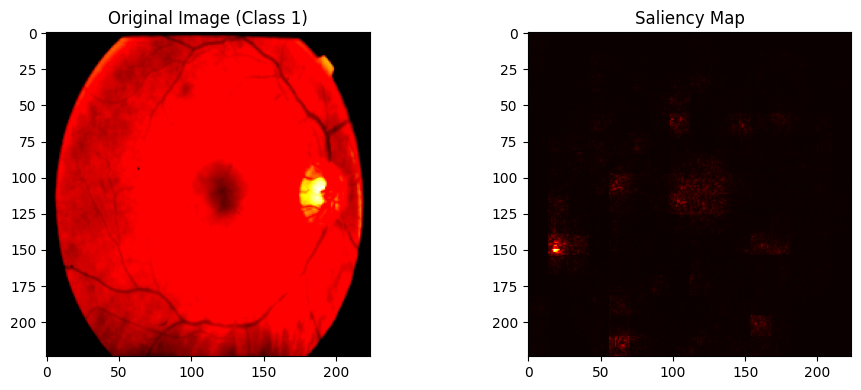

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


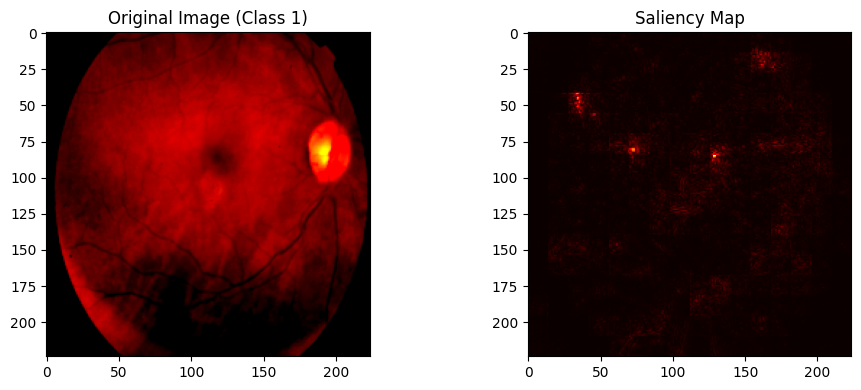

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


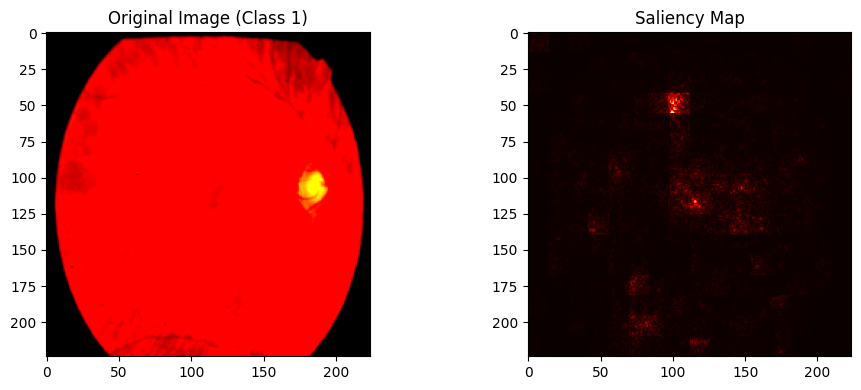

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


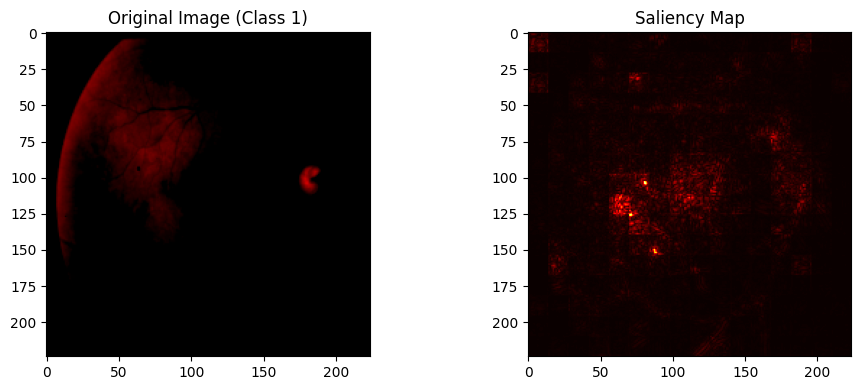

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


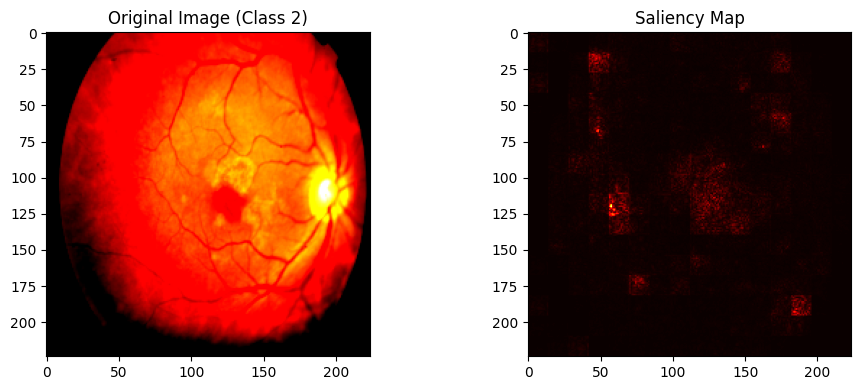

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


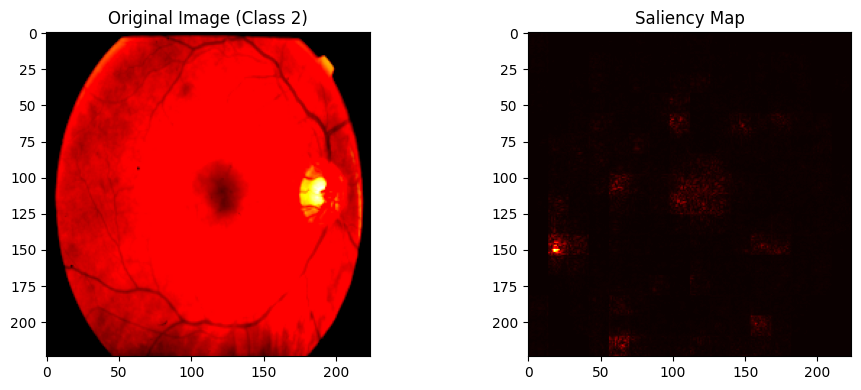

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


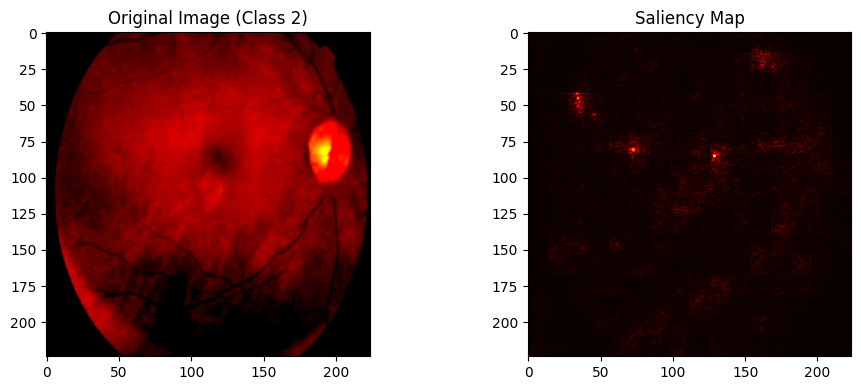

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


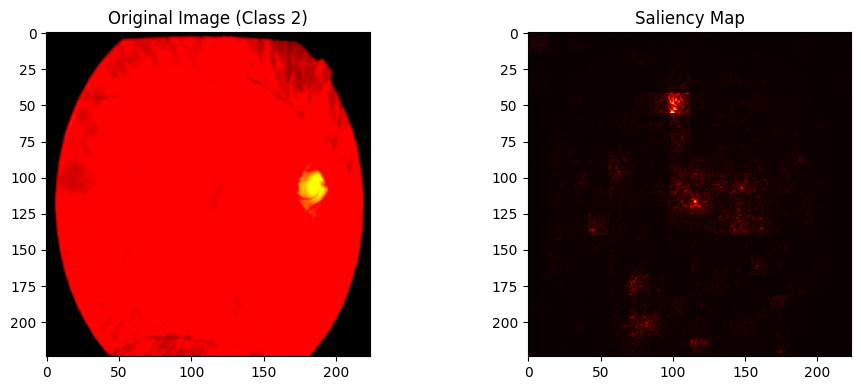

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


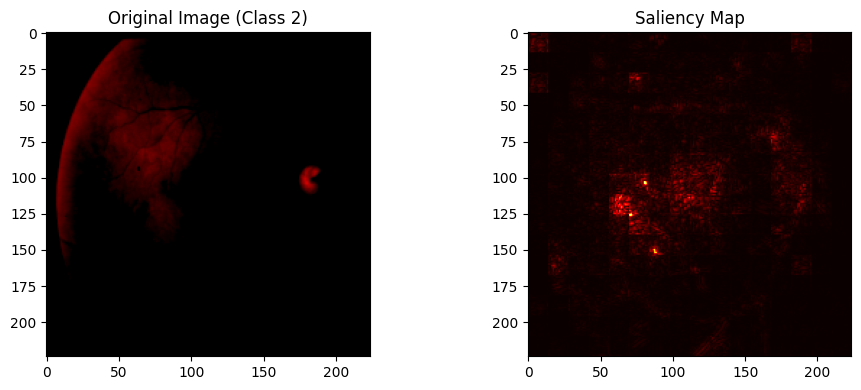

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)